# Qiskit 4 -2020/2021

&nbsp;

## Contents

&nbsp;

1. [Grover's Algorithm](#ga) 
    1. [How to implement and oracle](#oracle)
2. [Run in a quantum computer](#run)
3. [IGNIS](#ignis)
4. [Exercises](#exe)

## 1. Grover's Algorithm <a id ='ga'></a>

In 1996, Lov Grover preseted its fast algorithm for a database search problem.   This  algorithm  can  also  serve  as  a  general  trick  or  subroutine  to  obtain quadratic runtime enhancements in other algorithms.

Let’s consider a list with $0$ to $N$ items. In this list,  there is a particular object, $w$,  that we want to localize.

|$0$|$0$|$0$||$1$||$0$|$0$|
|-|-|-|-|-|-|-|-|
|$0$|$1$|$2$|...|$w$|...|$N-1$|$N=2^n$|

In a classical computer, the worst case scenario forces us to test all the  $N$  items before finding the wanted one, and on average we need to test  $N/2$  items. Quantum computing shows a real advantage by finding the targeted object in $\sqrt{N}$ steps. Additionally, this algorithm is also **generic** because it does not use the internal structure of the list. 

Similarly to what happened in the Deutsh-Jozsa algorithm, in Grover’s algorithm we also need an Oracle. A simple way to encode the oracle function is:

$$f(x)=0$$
$$f(w)=1$$

<img src="https://scx2.b-cdn.net/gfx/news/2018/groversearch.jpg" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="800 px" align="center">

The three stages of the 3-qubit Grover search algorithm: initialization, oracle, and amplification. Credit: C. Figgatt et al. Published in Nature Communications

In [46]:
# importing Qiskit
from qiskit import Aer, IBMQ
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, transpile

from qiskit.tools.visualization import plot_histogram, plot_state_city, plot_state_hinton

import matplotlib.pyplot as plt
%matplotlib inline

**1**  Initialize the system with the same amplitude in all possible input states.

$$ \sum_{x_i} \lvert x_i \rangle$$

**2** Apply $\sqrt{N}$ times the following unitary operations:

**a)** Quantum Oracle operator $U_w$. This operator is responsible for identifying the solutions to the problem and indicating the target.

$$-\alpha_m \lvert x_m \rangle + \beta \sum_{x_i \neq x_m}\lvert x_i \rangle$$ 

With this implementation, the phase of the marked state ($f(x_m) = 1$) rotates $\pi$ radians, while the others states keep the system unchanged.

## A. How to implement an oracle <a id ='oracle'></a>

### Recall how to change phase:

Z


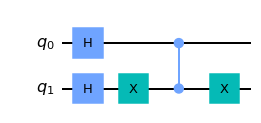

In [47]:
qc_help2 = QuantumCircuit(2)

# init
qc_help2.h(0)
qc_help2.h(1)

# oracle to change phase in |11__>
#qc_help2.x(0)
qc_help2.x(1)
qc_help2.cz(0,1)
qc_help2.x(1)
#qc_help2.x(0)

qc_help2.draw(output='mpl')

In [48]:
backend_state = Aer.get_backend('statevector_simulator') # the device to run on

In [49]:
result = execute(qc_help2, backend_state).result()
psi1  = result.get_statevector(qc_help2)

In [50]:
psi1

array([ 0.5+0.j, -0.5+0.j,  0.5+0.j,  0.5+0.j])

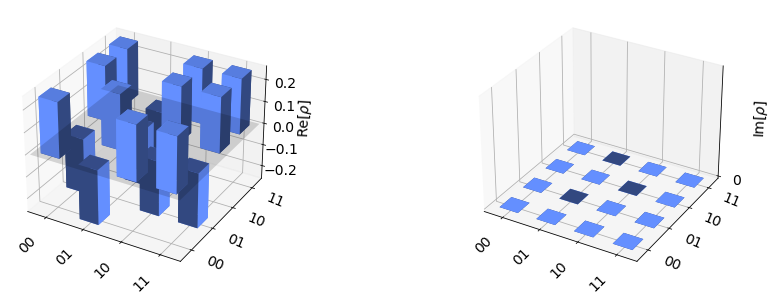

In [51]:
plot_state_city(psi1)

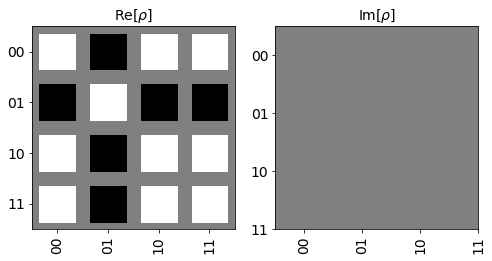

In [52]:
plot_state_hinton(psi1)

### Recall how de compose control-z using H and CX:

h cx h 

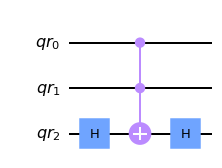

In [53]:
qr = QuantumRegister(3,'qr')
qc_help3 = QuantumCircuit(qr)


# oracle to change phase  |X >
#qc_help3.x(0)
#qc_help3.x(1)
#qc_help3.x(2)
qc_help3.h(qr[2])
qc_help3.ccx(qr[0],qr[1],qr[2])
qc_help3.h(qr[2])
#qc_help3.x(2)
#qc_help3.x(1)
#qc_help3.x(0)

qc_help3.draw(output='mpl')

In [54]:
result = execute(qc_help3, backend_state).result()
psi2  = result.get_statevector(qc_help3)

In [55]:
psi2.real

array([1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.01465364e-17, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

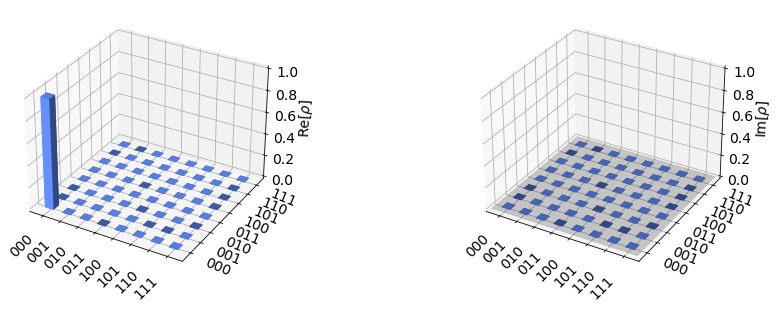

In [56]:
plot_state_city(psi2)

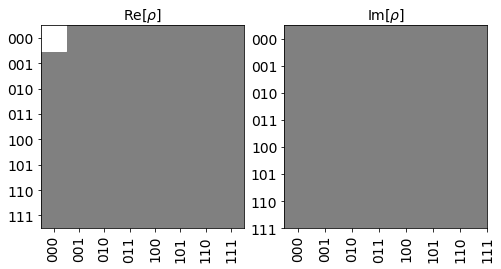

In [57]:
plot_state_hinton(psi2)

### How to decompose $C^n$X

In this implementation $w = 26$

In [58]:
w = 26

wb = bin(w)[2:] 

print(wb)

11010


In [59]:
x= len(wb)

print('number of qubits: ', x)

number of qubits:  5


<img src="https://i.stack.imgur.com/Wi9FAm.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="600 px" align="center">

$C^nU$ construction given by Nielsen & Chuang

In [60]:
def decompose_CnZ(circuit, qr_x, qr_a): 
    circuit.ccx(qr_x[0],qr_x[1],qr_a[0])
    
    for i in range(2, x-1):
        circuit.ccx(qr_x[i],qr_a[i-2],qr_a[i-1])
    
    circuit.cz(qr_a[x-3], qr_x[x-1])
    
    for i in range(x-2, 1, -1):
        circuit.ccx(qr_x[i],qr_a[i-2],qr_a[i-1])
    
    circuit.ccx(qr_x[0],qr_x[1],qr_a[0])

In [61]:
qr_a= QuantumRegister(x-2,'qr_aux')

In [62]:
qr_x = QuantumRegister(x, 'x')

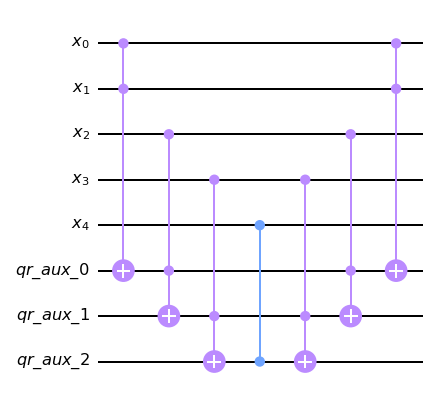

In [63]:
qc_help5= QuantumCircuit(qr_x, qr_a)
decompose_CnZ(qc_help5, qr_x, qr_a)

qc_help5.draw(output='mpl')

In [64]:
def select_w(circuit, qr_x):
    circuit.x(qr_x[0])
    circuit.x(qr_x[2])

def phase_oracle(circuit, qr_x, qr_a):
    select_w(circuit,qr_x)
    decompose_CnZ(circuit, qr_x, qr_a)
    select_w(circuit,qr_x)

### How to make the oracle $U_w$

**b)** Apply the diffusion transform $U_D$.  This operator implementation can be achieved by $U_D=WRW$, where $W$ is the Walsh-Hadamard transform matrix, and $R$ is a rotation matrix.

$$(2A + \alpha_m)\lvert x_m \rangle + (2A-\beta)\sum_{x_i\neq x_m} \lvert x_i \rangle $$

This step of the algorithm does not only flips the desired input but also increases its amplitude.

In [65]:
def diffuser(circuit, qr_x, qr_a):
    circuit.h(qr_x)
    circuit.x(qr_x)
    decompose_CnZ(circuit, qr_x, qr_a) #CCCCZ -> CCZ
    circuit.x(qr_x)
    circuit.h(qr_x)

These steps ( a) and b) ) have to be repeated roughly $\sqrt{N}$ times to get close to the optimal measure.

In [66]:
import math as m

times= round(m.sqrt(2**x))
print(times)

6


**3** Measure the qubits.

In [67]:
backend = Aer.get_backend("qasm_simulator")

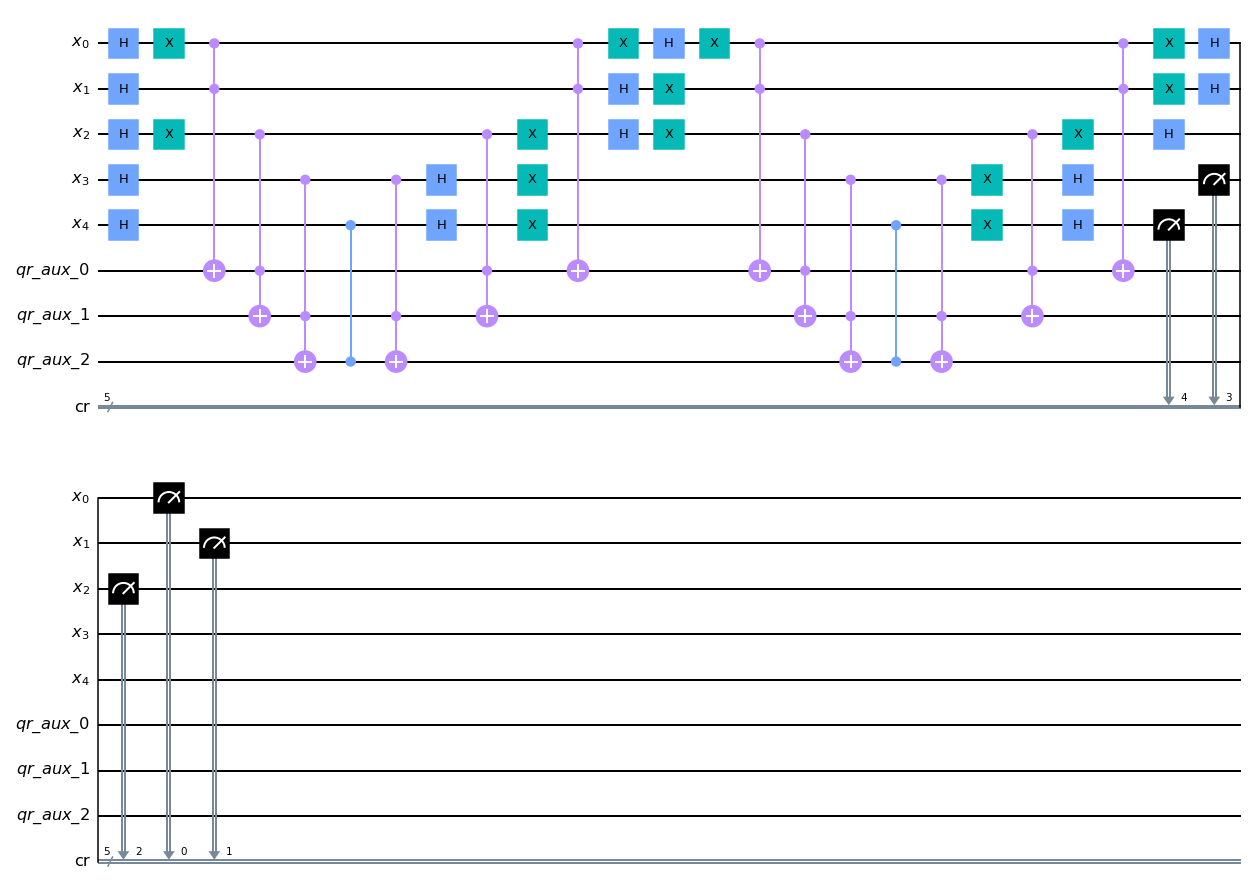

In [68]:
cr=ClassicalRegister(x,'cr')
qc_Grover= QuantumCircuit(qr_x,qr_a,cr)

# 1.init
qc_Grover.h(qr_x)

# 2.oracle and diffuser 

for t in range(1):
    # a)
    phase_oracle(qc_Grover, qr_x,qr_a)
    # b)
    diffuser(qc_Grover,qr_x,qr_a)

# 3.     
qc_Grover.measure(qr_x,cr)

qc_Grover.draw(output='mpl')

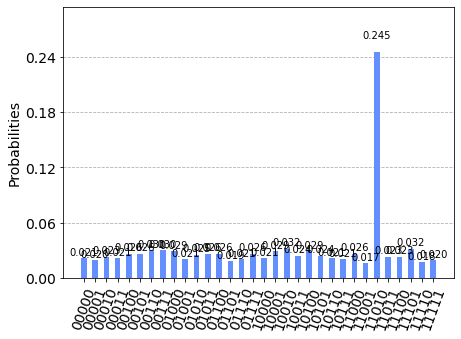

In [69]:
shots=1024
result = execute(qc_Grover, backend, shots=shots).result()
counts_sim = result.get_counts(qc_Grover)
plot_histogram(counts_sim)

In [70]:
qc_Grover.depth()

22

## 2. Run in a quantum computer <a id='run'></a>

In [71]:
provider = IBMQ.load_account()
provider.backends()

ibmqfactory.load_account:WARNING:2021-06-01 16:39:55,911: Credentials are already in use. The existing account in the session will be replaced.


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') fr

In [72]:
# Backend overview
import qiskit.tools.jupyter

%qiskit_backend_overview

In [73]:
from qiskit.tools.monitor import backend_overview, backend_monitor

backend_overview()

ibmq_manila                  ibmq_quito                   ibmq_belem
-----------                  ----------                   ----------
Num. Qubits:  5              Num. Qubits:  5              Num. Qubits:  5
Pending Jobs: 13             Pending Jobs: 1              Pending Jobs: 0
Least busy:   False          Least busy:   False          Least busy:   True
Operational:  True           Operational:  True           Operational:  True
Avg. T1:      159.8          Avg. T1:      88.9           Avg. T1:      83.6
Avg. T2:      64.4           Avg. T2:      80.4           Avg. T2:      76.4



ibmq_lima                    ibmq_santiago                ibmq_athens
---------                    -------------                -----------
Num. Qubits:  5              Num. Qubits:  5              Num. Qubits:  5
Pending Jobs: 46             Pending Jobs: 6              Pending Jobs: 1
Least busy:   False          Least busy:   False          Least busy:   False
Operational:  True           Operatio

In [74]:
backend_device = provider.get_backend('ibmq_16_melbourne')
print("Running on: ", backend_device)

Running on:  ibmq_16_melbourne


In [75]:
# See backend information
backend_device

<IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>

In [76]:
backend_monitor(backend_device)

ibmq_16_melbourne
Configuration
-------------
    n_qubits: 15
    operational: True
    status_msg: active
    pending_jobs: 260
    backend_version: 2.3.24
    basis_gates: ['id', 'rz', 'sx', 'x', 'cx']
    local: False
    simulator: False
    open_pulse: False
    backend_name: ibmq_16_melbourne
    dynamic_reprate_enabled: False
    processor_type: {'family': 'Canary', 'revision': 1.1}
    supported_instructions: ['cx', 'id', 'delay', 'measure', 'rz', 'sx', 'u1', 'u2', 'u3', 'x']
    allow_q_object: True
    max_shots: 8192
    online_date: 2018-11-06 05:00:00+00:00
    dtm: 0.2222222222222222
    n_registers: 1
    meas_map: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]]
    quantum_volume: 8
    multi_meas_enabled: True
    max_experiments: 75
    conditional: False
    memory: True
    allow_object_storage: True
    sample_name: family: Canary, revision: 1.1
    description: 15 qubit device
    coupling_map: [[0, 1], [0, 14], [1, 0], [1, 2], [1, 13], [2, 1], [2, 3], [2, 1

In [77]:
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [36]:
job_r = execute(qc_Grover, backend_device, shots=shots)

jobID_r = job_r.job_id()

print('JOB ID: {}'.format(jobID_r))

JOB ID: 60ae04ea338f561865237a3e


In [37]:
#ibmq_16_melbourne 4 times the oracle:
job_get=backend_device.retrieve_job("60ae04ea338f561865237a3e")

result_r = job_get.result()
counts_run = result_r.get_counts(qc_Grover)

IBMQJobInvalidStateError: 'Unable to retrieve result for job 60ae04ea338f561865237a3e. Job was cancelled.'

In [126]:
#ibmq_16_melbourne 1 times the oracle:
job_get=backend_device.retrieve_job("60ad1fd23936e139dff761c7")

result_r = job_get.result()
counts_run = result_r.get_counts()

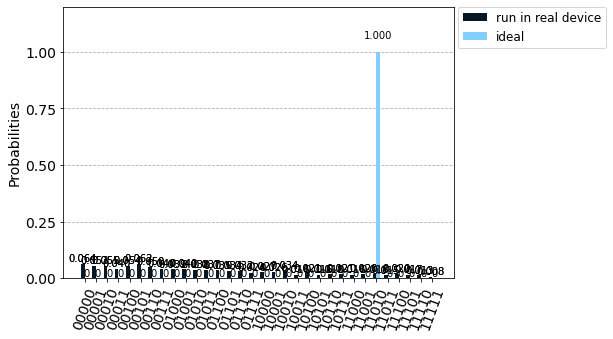

In [86]:
plot_histogram([counts_run, counts_sim ], legend=[ 'run in real device', 'ideal'], color=['#061727','#82cfff'])

## 3. IGNIS <a id='ignis'></a>

The measurement calibration is used to mitigate measurement errors.

In [7]:
# Import measurement calibration functions
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

### Calibration Matrices

**1** Generate a list of measurement calibration circuits.

Each circuit creates a basis state.

Since there we measure 5 qubits, we need $2^5 = 32$ calibration circuits.

In [88]:
# Generate the calibration circuits
qr = QuantumRegister(x)

# meas_calibs:
# list of quantum circuit objects containing the calibration circuits
# state_labels:
# calibration state labels
meas_calibs, state_labels = complete_meas_cal(qubit_list=[0,1,2,3,4], qr=qr, circlabel='mcal')

In [89]:
state_labels

['00000',
 '00001',
 '00010',
 '00011',
 '00100',
 '00101',
 '00110',
 '00111',
 '01000',
 '01001',
 '01010',
 '01011',
 '01100',
 '01101',
 '01110',
 '01111',
 '10000',
 '10001',
 '10010',
 '10011',
 '10100',
 '10101',
 '10110',
 '10111',
 '11000',
 '11001',
 '11010',
 '11011',
 '11100',
 '11101',
 '11110',
 '11111']

#### Computing the calibration matrix

If there was no noise in the device, the calibration matrix would be the identity matrix  $32 \times 32$.  Since we compute this matrix with a real quantum device there is going to be some noise. 

We could do this step with simulated noise from Qiskit Aer. 

In [90]:
#job_ignis = execute(meas_calibs, backend=backend_device, shots=shots)

jobID_run_ignis = job_ignis.job_id()

print('JOB ID: {}'.format(jobID_run_ignis))

JOB ID: 60a23a9f6a89d962aec5aeec


In [91]:
job_get=backend_device.retrieve_job("60a23a9f6a89d962aec5aeec")

cal_results = job_get.result()

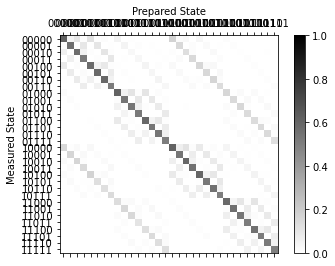

In [92]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')

# Plot the calibration matrix
meas_fitter.plot_calibration()

#### Analyzing results

The average assignment fidelity is the trace of the previous matrix.

In [93]:
# What is the measurement fidelity?
print("Average Measurement Fidelity: %f" % meas_fitter.readout_fidelity())

Average Measurement Fidelity: 0.553986


### Applying Calibration

Our raw data can be the `result_r`. We can apply a filter based on the calibration matrix to get mitigated counts.

In [94]:
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(result_r)
mitigated_counts = mitigated_results.get_counts()

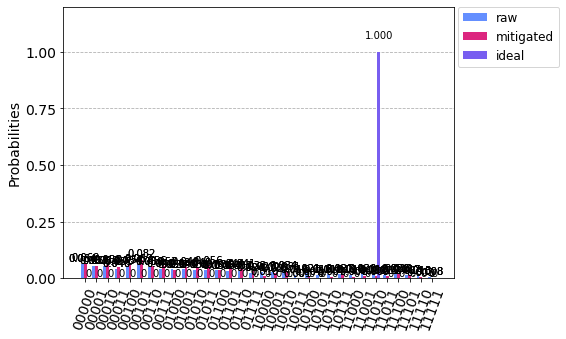

In [95]:
plot_histogram([counts_run, mitigated_counts, counts_sim], legend=['raw', 'mitigated', 'ideal'])

Still far from perfect.

Ref:

* [Measurement Error Mitigation - Qiskit](https://qiskit.org/documentation/tutorials/noise/3_measurement_error_mitigation.html)
* [Grover's Algorithm - Qiskit](https://qiskit.org/textbook/ch-algorithms/grover.html)
* [A fast quantum mechanical algorithm for database search](https://arxiv.org/abs/quant-ph/9605043)
* [Complete 3-Qubit Grover Search on a Programmable Quantum Computer](https://arxiv.org/abs/1703.10535)


# Exercises <a id='exe'></a>

Let $w = \mbox{your_student_number} `mod` 8 $. 

Repeat the Grover's algorithm implementation, run the circuit in a quantum computer, and apply ignis.

In [78]:
w = 2 % 8
print(w)

2


In [79]:
wb = bin(w)[2:] 

print(wb)

10


In [80]:
# 7 = {111} then we need 3 qubits

x = 3
print('number of qubits: ', x)

number of qubits:  3


In [81]:
qr_x = QuantumRegister(x, 'x')

In [82]:
backend = Aer.get_backend("qasm_simulator")

In [83]:
def initialize(qc_Grover,qubits):
    for q in qubits:
        qc_Grover.h(q)
    return qc_Grover

In [122]:
def phase_oracle2(nqubits):
    qc = QuantumCircuit(nqubits)
    qc.x(0)
    qc.x(2)
    qc.h(2)
    qc.ccx(0,1,2)
    qc.h(2)
    qc.x(0)
    qc.x(2)
    
    oracle = qc.to_gate()
    oracle.name = "U$_\omega$"
    
    return oracle


In [123]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    for qubit in range(nqubits):
        qc.h(qubit)
    
    for qubit in range(nqubits):
        qc.x(qubit)
        
    qc.h(nqubits-1)
    qc.ccx(0,1,2)
    qc.h(nqubits-1)
    
    for qubit in range(nqubits):
        qc.x(qubit)
        
    for qubit in range(nqubits):
        qc.h(qubit)
    
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    
    return U_s

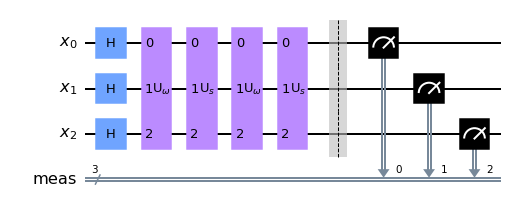

In [124]:

qc_Grover= QuantumCircuit(qr_x)

# init
qc_Grover = initialize(qc_Grover, qr_x)

# oracle and difuser 

for t in range(2):
    # phase oracle 2 
    qc_Grover.append(phase_oracle2(x), qr_x)
    
    # diffuser
    qc_Grover.append(diffuser(x), qr_x)

    

qc_Grover.measure_all()

qc_Grover.draw(output='mpl')

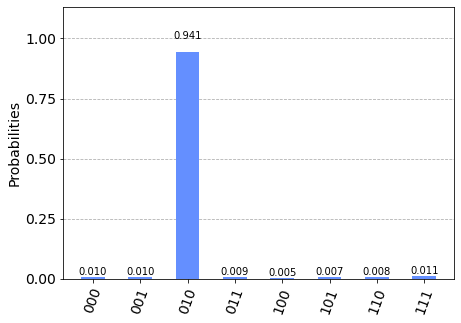

In [125]:
shots=1024
result = execute(qc_Grover, backend, shots=shots).result()
counts_sim = result.get_counts(qc_Grover)
plot_histogram(counts_sim)

In [23]:
qc_Grover.depth()

6

## Run in a quantum computer

In [29]:
# Backend overview
import qiskit.tools.jupyter

%qiskit_backend_overview

In [30]:
from qiskit.tools.monitor import backend_overview, backend_monitor

backend_overview()

ibmq_manila                  ibmq_quito                  ibmq_belem
-----------                  ----------                  ----------
Num. Qubits:  5              Num. Qubits:  5             Num. Qubits:  5
Pending Jobs: 17             Pending Jobs: 0             Pending Jobs: 3
Least busy:   False          Least busy:   True          Least busy:   False
Operational:  True           Operational:  True          Operational:  True
Avg. T1:      159.8          Avg. T1:      88.9          Avg. T1:      83.6
Avg. T2:      64.4           Avg. T2:      80.4          Avg. T2:      76.4



ibmq_lima                    ibmq_santiago                ibmq_athens
---------                    -------------                -----------
Num. Qubits:  5              Num. Qubits:  5              Num. Qubits:  5
Pending Jobs: 39             Pending Jobs: 3              Pending Jobs: 8
Least busy:   False          Least busy:   False          Least busy:   False
Operational:  True           Operational:  T

In [131]:
backend_device = provider.get_backend('ibmq_quito')
print("Running on: ", backend_device)

Running on:  ibmq_quito


In [32]:
# See backend information
backend_device

<IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>

In [132]:
backend_monitor(backend_device)

ibmq_quito
Configuration
-------------
    n_qubits: 5
    operational: True
    status_msg: active
    pending_jobs: 0
    backend_version: 1.1.2
    basis_gates: ['id', 'rz', 'sx', 'x', 'cx', 'reset']
    local: False
    simulator: False
    open_pulse: False
    backend_name: ibmq_quito
    dynamic_reprate_enabled: True
    meas_kernels: ['hw_boxcar']
    processor_type: {'family': 'Falcon', 'revision': 4, 'segment': 'T'}
    meas_levels: [1, 2]
    supported_instructions: ['measure', 'setf', 'rz', 'play', 'x', 'sx', 'acquire', 'u3', 'shiftf', 'delay', 'u2', 'cx', 'u1', 'id', 'reset']
    discriminators: ['linear_discriminator', 'hw_centroid', 'quadratic_discriminator']
    hamiltonian: {'description': 'Qubits are modeled as Duffing oscillators. In this case, the system includes higher energy states, i.e. not just |0> and |1>. The Pauli operators are generalized via the following set of transformations:\n\n$(\\mathbb{I}-\\sigma_{i}^z)/2 \\rightarrow O_i \\equiv b^\\dagger_{i} b_{i}

In [34]:
job_r = execute(qc_Grover, backend_device, shots=shots)

jobID_r = job_r.job_id()

print('JOB ID: {}'.format(jobID_r))

JOB ID: 60b642845042c4e29dcb5fc6


In [35]:
#ibmq_essex 1 times the oracle:
job_get=backend_device.retrieve_job("60b642845042c4e29dcb5fc6")

result_r = job_get.result()
counts_run = result_r.get_counts(qc_Grover)

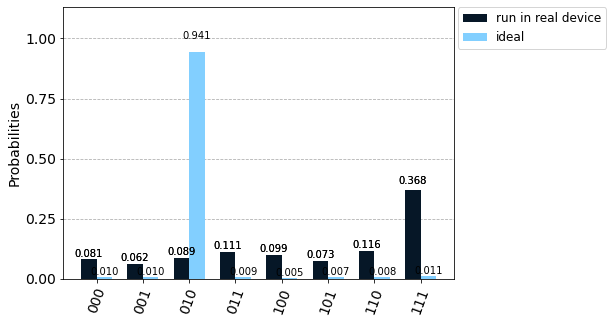

In [126]:
plot_histogram([counts_run, counts_sim ], legend=[ 'run in real device', 'ideal'], color=['#061727','#82cfff'])

## IGNIS

The measurement calibration is used to mitigate measurement errors.

### Calibration Matrices

**1** Generate a list of measurement calibration circuits.

Each circuit creates a basis state.

Since there we measure 3 qubits, we need $2^3 = 8$ calibration circuits.

In [127]:
# Generate the calibration circuits
qr = QuantumRegister(x)
meas_calibs, state_labels = complete_meas_cal(qubit_list=[0,1,2], qr=qr, circlabel='mcal')

In [128]:
state_labels

['000', '001', '010', '011', '100', '101', '110', '111']

#### Computing the calibration matrix

If there was no noise in the device the calibration matrix would be a identity matrix $32 \times 32$. Since we compute this matrix with a real quantum device there is going to be some noise. 

We could do this step with simulated noise from Qiskit Aer. 

In [133]:
job_ignis = execute(meas_calibs, backend=backend_device, shots=shots)

jobID_run_ignis = job_ignis.job_id()

print('JOB ID: {}'.format(jobID_run_ignis))

JOB ID: 60b65d6f9b4663c0904b3c46


In [134]:
job_get=backend_device.retrieve_job("60b65d6f9b4663c0904b3c46")

cal_results = job_get.result()

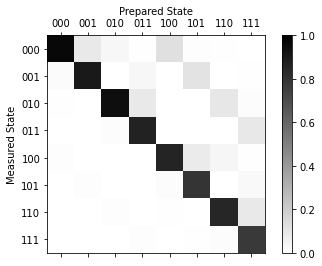

In [135]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')

# Plot the calibration matrix
meas_fitter.plot_calibration()

#### Analysing results

The average assignment fidelity is the trace of the previous matrix.

In [136]:
# What is the measurement fidelity?
print("Average Measurement Fidelity: %f" % meas_fitter.readout_fidelity())

Average Measurement Fidelity: 0.866699


### Applying Calibration

Our raw data can be the `result_r`. We can apply a filter based on the calibration matrix to get mitigated counts.

In [137]:
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(result_r)
mitigated_counts = mitigated_results.get_counts()

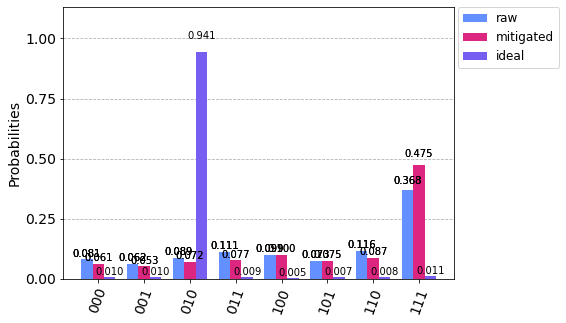

In [138]:
plot_histogram([counts_run, mitigated_counts, counts_sim], legend=['raw', 'mitigated', 'ideal'])

In [45]:
%qiskit_version_table